In [93]:
import numpy as np
from abc import abstractmethod
import pandas as pd
from datetime import datetime
from scipy import stats
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.graph_objects as go
import plotly.express as px
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import multiprocessing
from typing import Literal
import scipy.optimize as opt

We try to fit the implied volatility surface using the SVI model and compute the probability distribution implied from option prices. The data represents options on Bitcoin from the Deribit exchange.

## Data Preprocessing

In [89]:
data = pd.read_csv('/content/options_btc_slices.csv')

# Extract maturities
data['maturity'] = data.apply(lambda instrument: instrument['instrument_name'].split('-')[1], axis=1)

In [ ]:
def expiration(today: str):
  current_date = datetime.strptime(today, '%d%b%y')
  def get_days_to_expiration(instrument: pd.Series) -> float:
    maturity = instrument['maturity']
    maturity_date = datetime.strptime(maturity, '%d%b%y')
    expiration = maturity_date - current_date
    days_to_expiration = expiration.days
    return days_to_expiration
  return get_days_to_expiration

In [ ]:
# Convert maturities to expiries
data['expiry'] = data.apply(expiration(today='21JUL23'), axis=1)

In [ ]:
class DataProcess:
  def __init__(self, data: pd.DataFrame):
    self.data = data
    self.data_proc = self.data_preprocessing()
    self.slices = self.reformat_to_dict()

  def data_preprocessing(self) -> pd.DataFrame:
    data["spread_vol"] = data.ask_iv - data.bid_iv
    data_proc = data[data.spread_vol>=0]
    data_proc = data_proc[data_proc.bid_iv > 0]
    data_proc = data_proc[data_proc.ask_iv > 0]
    data_proc["moneyness"] = np.array(np.log(data_proc.strike/data_proc.underlying_price))
    data_type = DataProcess.call_put_merge(data_proc)
    return data_type

  def reformat_to_dict(self) -> dict:
    d = dict()
    ttm_vec = self.data_proc.expiry.unique()
    for ttm in ttm_vec:
      df = self.data_proc[self.data_proc.expiry == ttm]
      moneyness = df['moneyness']
      iv = df.mark_iv
      weight = df['spread_vol']
      d[ttm] = [np.array(moneyness),np.array(iv),np.array(weight)]
    return d

  @abstractmethod
  def call_put_merge(data):
    put_otm = data[(data.moneyness <0)&(data.optionType=="P")]
    call_otm = data[(data.moneyness>0)&(data.optionType=="C")]
    data_merged = pd.concat([call_otm,put_otm])
    return data_merged

In [ ]:
dpp = DataProcess(data=data)

## Implied Volatility surface construction:

Many types of implied volatility models can be used[3]. We use here a well known parametric model called SVI by Jim Gatheral (2004)[1]. SVI tries to fit the implied variance via 5 parameters that control important properties of the skew (vertical level,horizental translation, roation, asymmetry and convexity around ATM)

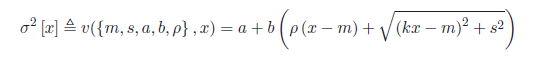

The procedure of construction of the Implied Volatility surface is as follows:


1.   For each Time to maturity we fit the SVI model to that slice and store its parameters (skew)
2.   We interpolate the following function: iv**2 * T for each strike/moneyness (Term Structure)


The calibration function is as follows to fit the SVI model is as follows:

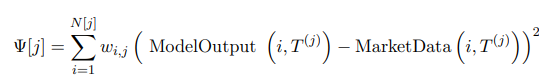

We use the inverse of spreads as wieghts to emphasise liquid options in the calibration function.

We follow [2] for the calibration procedure. The idea is to use a variable transformation to have a linear system and reduce the number of parameters. Therefore, we reduce the computations since 5 parameters can be complicated for the optimization.

In [ ]:
class TermStructure:

    def __init__(self, expiries: np.ndarray, vols: np.ndarray, base_iv: np.ndarray, base_ttm: np.ndarray):
        """
        Args:
            expiries: expanded expiries
            vols: expanded transformation of iv (e.g total_variance)
            base_iv: initial iv points
            base_ttm: initial expiries points
        """
        self.expiries = expiries
        self.vols = vols
        self.base_iv = base_iv
        self.base_ttm = base_ttm

    def finite_difference(self, x, y):
        """
        compute the derivatives of vols with respect to expiries via central finite difference.
        Args:
            x: expiries
            y: vols

        Returns:
            dvol/dtau
        """
        dydx = []
        edge = len(y)
        for i in range(edge):
            if i == 0:
                accrois = (y[i + 1] - y[i]) / (x[i + 1] - x[i])
                dydx.append(accrois)
            elif i == edge - 1:
                accrois = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
                dydx.append(accrois)
            else:
                accrois = (y[i + 1] - y[i - 1]) / (2 * (x[i + 1] - x[i - 1]))
                dydx.append(accrois)
        return np.array(dydx)

    def get_ts_func(self, interpolator: Literal['cs', 'lin', 'hs'] = 'hs'):
        """
        Interpolate the term structure using the available methods.
        Args:
            interpolator: Name of the interpolation function

        Returns:
        interpolation function on the data provided.
        """
        if interpolator == "lin":
            interp_func = interp1d(self.expiries, self.vols, fill_value="extrapolate")
        elif interpolator == "cs":
            interp_func = CubicSpline(self.expiries, self.vols, extrapolate=True)
        else:
            dsigdt = self.finite_difference(self.base_ttm, self.base_iv)
            dydx = self.base_iv ** 2 + 2 * self.base_ttm * self.base_iv * dsigdt
            interp_func = CubicHermiteSpline(self.expiries, self.vols, dydx=np.insert(dydx, 0, 0), extrapolate=True)
        return interp_func

In [ ]:
class SVI:

    def __init__(self, data: dict, init_ms: list, parallel: bool = False):
        self.data = data
        self.init_ms = init_ms
        self.parallel = parallel
        self.opt_params_matrix = self.params_matrix()
        self.opt_params_dict = self.params_to_dict()

    @staticmethod
    def svi(x, a, b, rho, m, s):
        return a + b * (rho * (x - m) + np.sqrt((x - m) ** 2 + s ** 2))

    @staticmethod
    def svi_transformed(y, a, d, c):
        return a + d * y + c * np.sqrt(y ** 2 + 1)

    @staticmethod
    def get_original_params(parameters: list) -> list:
        a, d, c, m, s = parameters
        original_params = [a, c / s, d / c, m, s]
        return original_params

    @staticmethod
    def compute_transformed_params(implied_vars, x, _m, _s):
        y = (x - _m) / _s
        h = max(_s, 10 ** (-7))
        bounds = ((0, -4 * h, 0), (max(max(implied_vars), 10 ** (-7)), 4 * h, 4 * h))
        z = np.sqrt(y ** 2 + 1)
        A = np.column_stack([np.ones(len(implied_vars)), y, z])
        a, d, c = opt.lsq_linear(A, implied_vars, bounds, tol=10 ** (-12), verbose=False).x
        return a, d, c

    @staticmethod
    def get_objective_func(implied_vars, x, weights):
        def loss(ms):
            _m, _s = ms
            _y = (x - _m) / _s
            _a, _d, _c = SVI.compute_transformed_params(implied_vars, x, _m, _s)
            sum_se = np.mean(weights * (SVI.svi_transformed(_y, _a, _d, _c) - implied_vars) ** 2)
            return sum_se

        return loss

    def calibration(self, implied_vars: np.ndarray, moneyness: np.ndarray, weights: np.ndarray,
                    method_name: str, epsilon=10 ** (-12)):

        m_opt, s_opt = opt.minimize(SVI.get_objective_func(implied_vars, moneyness, weights), self.init_ms,
                                    method=method_name, tol=epsilon).x
        a_opt, d_opt, c_opt = SVI.compute_transformed_params(implied_vars, moneyness, m_opt, s_opt)
        result = np.array([a_opt, d_opt, c_opt, m_opt, s_opt])
        opt_parameters = SVI.get_original_params(result)
        return opt_parameters

    def calibrate_slice(self, ttm):
        mkt_moneyness, mkt_ivs, spread_vols = self.data[ttm]
        tau = ttm / 365
        mkt_tot_vars = (mkt_ivs / 100) ** 2 * tau
        a, b, rho, m, s = self.calibration(implied_vars=mkt_tot_vars, moneyness=mkt_moneyness,
                                           weights=1 / (spread_vols / 100) ** 2, method_name="Nelder-Mead")
        return [a, b, rho, m, s]

    def params_matrix(self):
        sorted_ttm_vec = np.array(sorted(self.data.keys()))
        sorted_ttm_vec = sorted_ttm_vec[sorted_ttm_vec > 0]
        n_slices = len(sorted_ttm_vec)
        params_matrix = np.zeros((n_slices, 6))
        params_matrix[:, 0] = sorted_ttm_vec
        if self.parallel:
            with multiprocessing.Pool() as pool:
                params_list = pool.map(self.calibrate_slice, sorted_ttm_vec)
        else:
            params_list = []
            for expiry in sorted_ttm_vec:
                slice_params = self.calibrate_slice(expiry)
                params_list.append(slice_params)
        params_matrix[:, 1:] = np.array(params_list)
        return params_matrix

    def params_to_dict(self):
        dict_params = {slc[0]: {'a': slc[1], 'b': slc[2], 'rho': slc[3], 'm': slc[4], 's': slc[5]}
                       for slc in self.opt_params_matrix}
        return dict_params

    def implied_vol(self, m, t, model: Literal['cs', 'lin', 'hs'] = 'lin'):
        if t in self.opt_params_dict:
            opt_params = self.opt_params_dict[t]
            y = self.svi(m, opt_params['a'], opt_params['b'], opt_params['rho'], opt_params['m'],
                         opt_params['s'])
            tau = t / 365
            final_iv = np.array(np.sqrt(y / tau) * 100)
        else:
            opt_params = self.opt_params_matrix
            # vector of implied vol needed for interpolation
            y = self.svi(m, opt_params[:, 1], opt_params[:, 2], opt_params[:, 3], opt_params[:, 4],
                         opt_params[:, 5])
            condition = (y >= 0)
            y = y[condition]
            market_ttms = opt_params[:, 0][condition]
            x = np.insert(opt_params[:, 0][condition], 0, 0)
            ys = np.insert(y, 0, 0)
            base_ivs = np.sqrt(y)
            ts = TermStructure(expiries=x / 365, vols=ys, base_iv=base_ivs, base_ttm=market_ttms / 365).get_ts_func(
                model)
            tau = t / 365
            lin = ts(tau)
            final_iv = np.array(np.sqrt(lin / tau) * 100)
        return final_iv

In [ ]:
svi_data = dpp.slices
proc_data = dpp.data_proc

In [ ]:
svi_model = SVI(data= svi_data, init_ms= [0.01, 0.01], parallel=True)

### Test for each slice

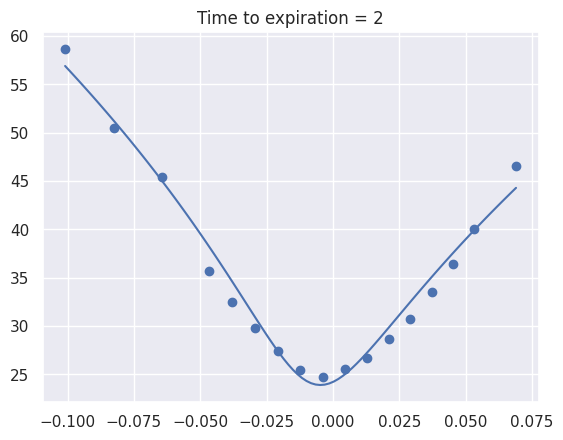

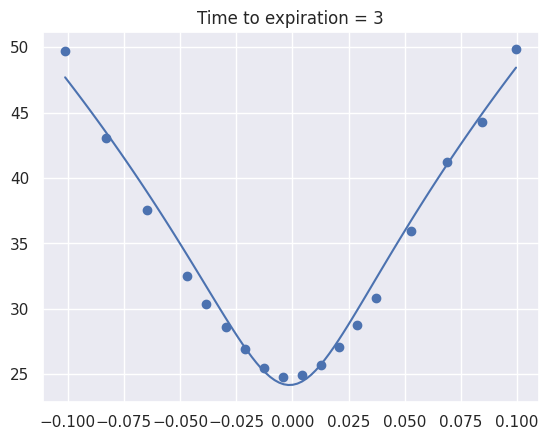

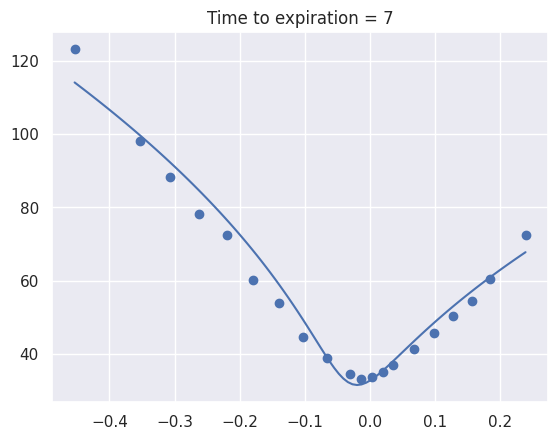

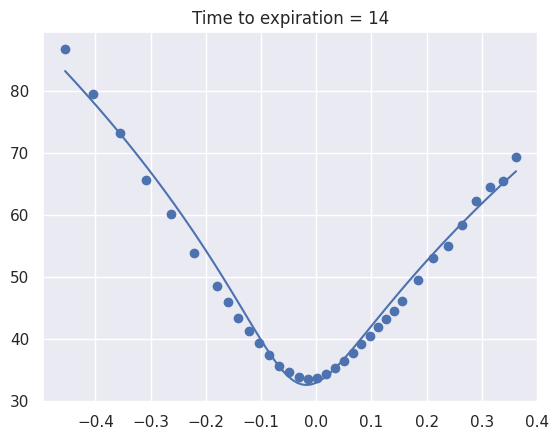

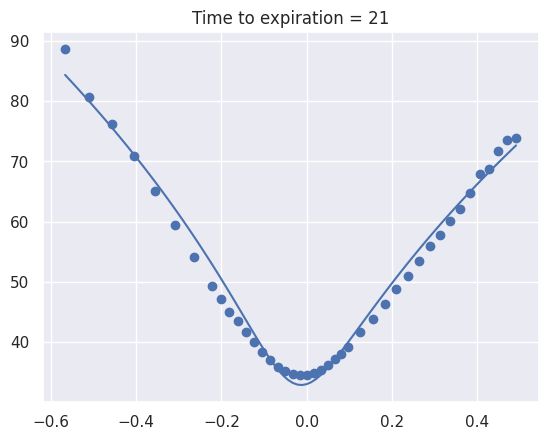

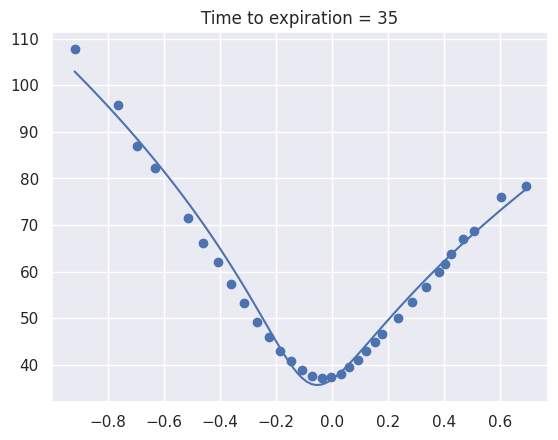

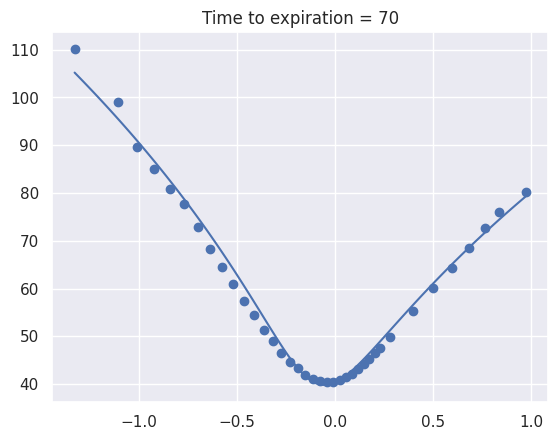

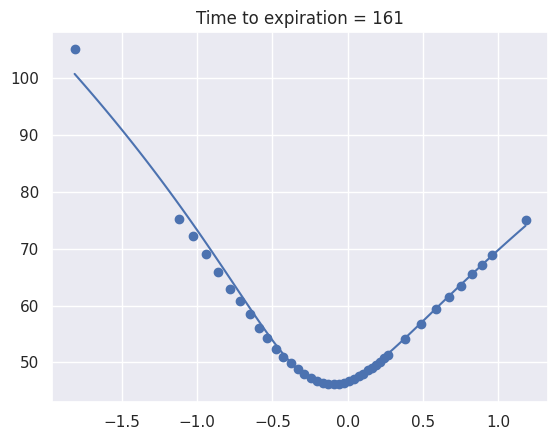

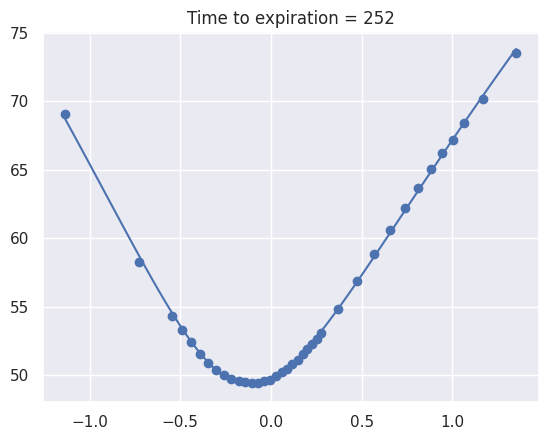

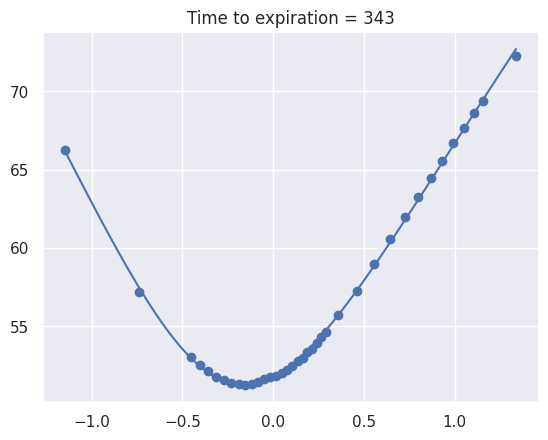

In [ ]:
for ttm in sorted(svi_data.keys())[1:]:
  slc = proc_data[proc_data.expiry == ttm]
  bid_ivs = slc.bid_iv
  ask_ivs = slc.ask_iv
  mkt_moneyness, mkt_ivs, weights = svi_data[ttm]
  moneyness_mesh = np.linspace(min(mkt_moneyness), max(mkt_moneyness), 100)
  model_ivs = svi_model.implied_vol(moneyness_mesh, ttm)
  plt.title('Time to expiration = {}'.format(ttm))
  plt.scatter(mkt_moneyness,mkt_ivs, label = 'market ivs')
  plt.scatter(mkt_moneyness, bid_ivs)
  plt.scatter(mkt_moneyness, ask_ivs)
  plt.plot(moneyness_mesh, model_ivs, label = 'svi')
  plt.show()

## 3d Representation of the IVS

In [ ]:
moneyness = np.linspace(-1,1,100)
T = np.linspace(7,365,100)
xx,yy = np.meshgrid(moneyness,T)
Z = np.array([svi_model.implied_vol(m,t) for KT,TT in zip(xx,yy) for m,t in zip(KT,TT)]).reshape(xx.shape[0],xx.shape[1])

In [ ]:
fig = go.Figure(data = [go.Surface(z=Z,x=moneyness,y=T)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Implied Volatility Surface', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),scene = dict(
                    xaxis_title='Moneyess = Ln(K/F)',
                    yaxis_title='Time to expiration (days)',
                    zaxis_title='Implied Vol'),
                  width=680, height=680,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.write_html("strike_surface.html")
fig.show()

## Probability Distribution implied from option prices

Given That we have the implied volatility surface. We can obtain a better estimate for option prices given any strike and Time to maturity. We Follow Breeden-Litzenberger approach to extract probability distribution from option prices.

In [111]:
def bsm_price(option_type, k, s, tau, sigma, r, q):
    # calculate the bsm price of European call and put options
    d1 = (np.log(s / k) + (r - q + sigma ** 2 * 0.5) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - (sigma) * np.sqrt(tau)
    if option_type == 'C':
        price = np.exp(-r * tau) * (s * np.exp((r - q) * tau) * stats.norm.cdf(d1) - k * stats.norm.cdf(d2))
        return price
    elif option_type == 'P':
        price = np.exp(-r * tau) * (k * stats.norm.cdf(-d2) - s * np.exp((r - q) * tau) * stats.norm.cdf(-d1))
        return price
    else:
        print('No such option type %s') % option_type

In [112]:
def option_value(model,k,f,t,r,q,option_type):
    m = np.log(k/f)
    vol = model.implied_vol(m, t)
    sigma, tau = vol/100, t/365
    p0 = bsm_price(option_type, k, f, tau, sigma, r, q)
    return p0

In [119]:
def pdf(model, k, s, t, r, q, option_type, h=1):
    curr_value = option_value(model, k, s, t, r, q, option_type)
    curr_h = option_value(model, k+h, s, t, r, q, option_type)
    curr_l = option_value(model, k-h, s, t, r, q, option_type)
    proba = (curr_h + curr_l - 2*curr_value)/(h**2)
    proba[proba <0] = 0
    return proba

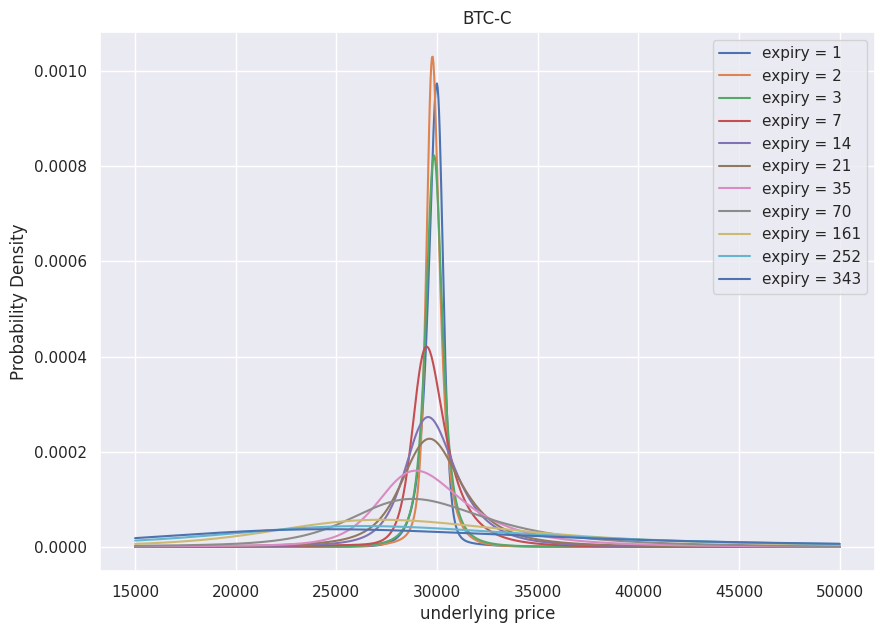

In [122]:
plt.figure(figsize=(10,7))
plt.title("BTC-C")
option_type = 'C'
k_range = np.linspace(15000,50000,1000)
for t in sorted(proc_data.expiry.unique()):
  slc = proc_data[proc_data.expiry == t]
  f = slc.underlying_price.mean()
  proba_vec = pdf(svi_model, k_range,f,t, 0, 0, option_type)
  plt.plot(k_range,proba_vec,label = "expiry = {}".format(t))
plt.xlabel("underlying price")
plt.ylabel("Probability Density")
plt.legend(loc = "best")

## References


[1] Gatheral, J., A parsimonious arbitrage-free implied volatility parameterization with application to the
valuation of volatility derivatives, Presentation at Global Derivatives, 2004

[2] Zeliade Systems, Quasi-explicit calibration of Gatheral’s SVI model, Zeliade white paper, 2009.

[3] Cristian Homescu, "Implied volatility surface: construction methodologies and
characteristics".
